In [1]:
import Tiled_Classification_RF as TCRF
import os, tempfile
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
import pandas as pd # handling large data as table sheets
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
import datetime

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()
from GIStools.GIStools import preprocess_SfM_inputs
from GIStools.Stitch_Rasters import stitch_rasters
from GIStools.Grid_Creation import create_grid
from GIStools.Raster_Matching import pad_rasters_to_largest
from input_parameters import InputParameters

In [2]:
#-------------------Required User Defined Inputs-------------------#
params = InputParameters()

DEM_path = params.DEM_path
ortho_path = params.ortho_path
output_folder = params.output_folder
training_path = params.training_path
validation_path = params.validation_path
attribute = params.attribute
validation_path_2 = params.validation_path_2
grid_ids = params.grid_ids
process_training_only = params.process_training_only
est = params.est
n_cores = params.n_cores
gradient_boosting = params.gradient_boosting
verbose = params.verbose
stitch = params.stitch

#--------------------Input Preparation-----------------------------#
#Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#List of grid-clipped images to classify and associated id values
in_dir = os.path.join(output_folder, 'RF_Tiled_Inputs')
#output folder for list of img_path_list grid-clipped classified images

# directory, where the classification image should be saved:
output_folder = os.path.join(output_folder, 'RF_Results')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
classification_image = os.path.join(output_folder, 'Classified_Training_Image.tif')
classified_tile_folder = os.path.join(output_folder, 'Classified_Tiles')
if not os.path.exists(classified_tile_folder) and process_training_only == False:
    os.makedirs(os.path.join(classified_tile_folder))

In [3]:
#==================== Preprocessing ====================#
    #Create grid cells to process large rasters in chunks. 
#Each grid cell is the size of the extent training and validation shapefiles
train_val_grid_id, grid_path, cell_dim = create_grid([training_path,validation_path], DEM_path, in_dir)
if process_training_only: #preprocess_function will now only process the training tile
    grid_ids.append(train_val_grid_id)

print('Training Grid ID: {}'.format(train_val_grid_id))     
#Bands output from preprocess function: Roughness, R, G, B, Saturation, Excessive Green Index
grid_ids = preprocess_SfM_inputs(grid_path, ortho_path, DEM_path, grid_ids, in_dir, verbose=verbose) #Prepare input stacked rasters for random forest classification
print('Grid IDs to process: {}'.format(grid_ids))
#Ensure all rasters are the same size by padding smaller rasters with 0s. Having raster tiles of identical sizes is required for random forest classification
raster_dims = pad_rasters_to_largest(in_dir, verbose=verbose)
img_path_list, id_values = TCRF.find_files(in_dir) # list of all grid-clipped images to classify and associated id values
attribute_names = TCRF.print_attributes(training_path) # print the attributes in the training shapefile


Training Grid ID: 29
Processing grid cell 1 of 1


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'Y:\\ATD\\GIS\\East_Troublesome\\RF Vegetation Filtering\\LM2\\Results\\LM2_2023___070923_GB\\RF_Tiled_Inputs\\Grid_29\\Thumbs.db'

Extracting image data from: Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2\Results\LM2_2023___070923_GB\RF_Tiled_Inputs\stacked_bands_tile_input_29.tif
Image extent: 5623 x 10102 (row x col)
Number of Bands: 6
Band 1 importance: 0.14100211876067467
Band 2 importance: 0.23535677372130245
Band 3 importance: 0.03614323013065078
Band 4 importance: 0.5481227811243755
Band 5 importance: 0.003694340825338109
Band 6 importance: 0.03568075543765854
predict      1      2      3      4     5     All
truth                                            
1        88287      6      2      1     1   88297
2            3  50898    590   2300   486   54277
3            4    392  10085      0     0   10481
4            2   1258      0  93952   130   95342
5            0    439      0    203  1631    2273
All      88296  52993  10677  96456  2248  250670


ValueError: too many values to unpack (expected 2)

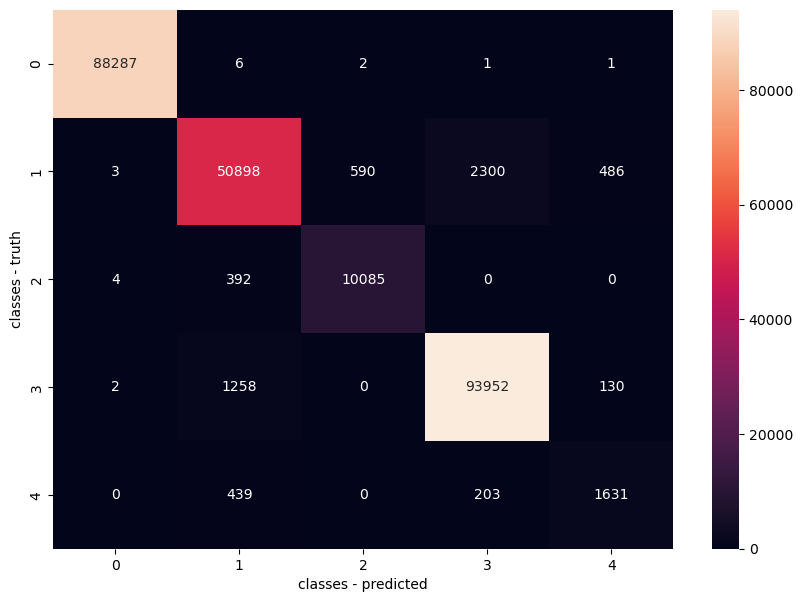

In [ ]:

#===========================Main Classification Loop===========================#
train_tile_path = os.path.join(in_dir, f'stacked_bands_tile_input_{train_val_grid_id}.tif') # grid-clipped-image containing the training data
results_txt = os.path.join(output_folder, 'Results_Summary.txt') # directory, where the all meta results will be saved
TCRF.print_header(results_txt, DEM_path, ortho_path, train_tile_path, training_path, validation_path, img_path_list, attribute) # print the header for the results text file
train_tile, train_tile_3Darray = TCRF.extract_image_data(train_tile_path, results_txt, est, log=True) # extract the training tile image data
# Extract training data from shapefile
X_train, y_train, labels, roi = TCRF.extract_shapefile_data(training_path, train_tile, train_tile_3Darray, results_txt, attribute, "TRAINING")

if gradient_boosting:
    rf, rf2 = TCRF.train_GB(X_train, y_train, train_tile, results_txt, est, n_cores, verbose) # train the gradient boosting classifier
else:
    rf, rf2 = TCRF.train_RF(X_train, y_train, train_tile, results_txt, est, n_cores, verbose) # train the random forest classifier


train_tile_2Darray = TCRF.flatten_raster_bands(train_tile_3Darray) # Convert NaNs to 0.0
class_prediction = TCRF.predict_classification(rf, train_tile_2Darray, train_tile_3Darray) # predict the classification for each pixel using the trained model
masked_prediction = TCRF.reshape_and_mask_prediction(class_prediction, train_tile_3Darray) # mask the prediction to only include bare earth and vegetation
TCRF.save_classification_image(classification_image, train_tile, train_tile_3Darray, masked_prediction) # save the masked classification image
# Extract validation data from shapefile
X_v, y_v, labels_v, roi_v = TCRF.extract_shapefile_data(validation_path, train_tile, class_prediction, results_txt, attribute, "VALIDATION") 
TCRF.model_evaluation(X_v, y_v, labels_v, roi_v, class_prediction, results_txt) # evaluate the model using the validation data

del train_tile # close the image dataset

In [ ]:
print(train_tile_3Darray.shape)
print(train_tile_2Darray.shape)
print(X_v.shape)
print(y_v.shape)

#get rows and cols from train tile path
#open train tile path
train_tile = gdal.Open(train_tile_path)
rows = train_tile.RasterYSize
cols = train_tile.RasterXSize
bands = train_tile.RasterCount
print(f"Rows: {rows}, Cols: {cols}, Bands: {bands}")
print(f"Class prediction shape: {class_prediction.shape}")

(5623, 10102, 6)
(56803546, 6)
(98886,)
(98886,)
Rows: 5623, Cols: 10102, Bands: 6
Class prediction shape: (5623, 10102)
